In [3]:
import snowflake.snowpark as snowpark
from snowflake.snowpark import Session
from snowflake.core import Root
from snowflake.snowpark.functions import col
import fsspec

In [8]:
# Add your session parameters
connection_parameters = {
    "account": "<account>",
    "user": "<user>",
    "password": "<password>",
}

# Create your Snowpark connection session
session = Session.builder.configs(connection_parameters).create()

# Your code goes here, inside the "main" handler.
root = Root(session)

db_name = 'FSI_PYTHON_API_DB'
schema_name = 'FSI_PYTHON_SCHEMA'
role_name = 'FSI_ROLE'
warehouse_name = 'FSI_WAREHOUSE'

# Assign role to enable privileges to make changes to your database
session.use_role('ACCOUNTADMIN')

### Set current user
current_user = session.sql("SELECT CURRENT_USER()").collect()[0][0]


### Create database
create_database_query = f"""CREATE OR REPLACE DATABASE {db_name};"""

session.sql(create_database_query)
session.use_database(db_name)

### Create schema
create_schema_query = f"""CREATE OR REPLACE SCHEMA {schema_name};"""
session.sql(create_schema_query).collect()
session.use_schema(schema_name)

### Use warehouse
session.use_warehouse(warehouse_name)

# Downlaod real Census CPS ASEC health insurance data March 2024
fs = fsspec.filesystem("zip", fo="https://www2.census.gov/programs-surveys/cps/datasets/2024/march/asecpub24csv.zip")
filelist = fs.ls("", detail=True)

In [11]:
import pandas as pd
from snowflake.connector.pandas_tools import write_pandas

### Setup the Data
## We will use session.sql commands to run basic SQL for setting up our required data

# Key demographic variables for your model:
age_var = 'A_AGE'                    # Age
sex_var = 'A_SEX'                     # Sex (1=Male, 2=Female)
race_var = 'PRDTRACE'                 # Race
hispanic_var = 'PEHSPNON'             # Hispanic origin
marital_var = 'A_MARITL'              # Marital status
education_var = 'A_HGA'               # Educational attainment
employment_var = 'PEMLR'              # Employment status
family_size_var = 'A_FAMNUM'          # Family size
income_var = 'PTOTVAL' or 'PTOT_R'    # Total person income
state_var = 'GESTFIPS'                # State FIPS code

# Health insurance coverage variables (your target variable):
# These are more complex - multiple variables for different types
employer_cov = 'COV_GH'               # Group health (employer)
medicaid_cov = 'COV_MCAID'            # Medicaid
medicare_cov = 'MCARE'                # Medicare  
private_cov = 'COV_HI'                # Any private coverage

df_dict = {}
desired_columns = ['PPPOS', 'GEDIV', 'GEREG', 'HEFAMINC', 'HPCTCUT', 'HCOV', 'COV', 'HSUP_WGT', 'A_AGE', 
                   'A_SEX', 'PRDTRACE', 'PEHSPNON', 'A_MARITL', 'A_HGA', 'PEMLR', 'A_FAMNUM', 'PTOTVAL',
                  'COV_GH', 'COV_MCAID', 'MCARE', 'COV_HI', 'GESTFIPS']
counter = 0

for csv_file in filelist:
    with fs.open(csv_file['filename']) as f:
        # Read in chunks to avoid memory issues
        df = pd.read_csv(f, low_memory=True) # Enable low_memory
        columns_to_keep = []
        try:
            print("📥 Downloading Census data...")
            columns_to_keep.extend([col for col in desired_columns if col in df.columns])
            df_dict[f'df{counter}'] = { 'name': f'df{counter}', 'data': df[columns_to_keep], 'columns': columns_to_keep }
        except Exception as e:
            print(e)
        counter += 1

table_columns = []


for df in df_dict:    
    table_name = df_dict[df]['name']

    session.sql(f"CREATE OR REPLACE TABLE {table_name};")
    
    if len(table_columns) != 0:
        #df_schema = "StructType([" + ", ".join(f'StructField("{col}", StringType(255))' for col in dataframe) + "])"
        df_schema = "[" + ", ".join(col for col in df_dict[df]['data'].columns) + "]"
        session.write_pandas(df_dict[df]['data'], f'{table_name}_new', database=db_name, schema=schema_name, auto_create_table=True, quote_identifiers=True, overwrite=True)

📥 Downloading Census data...
📥 Downloading Census data...
📥 Downloading Census data...
📥 Downloading Census data...


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Health Insurance Coverage Classification Model
# Using CPS ASEC Data to Predict Coverage Type

# The dataframe we will use for this analysis will be the 4th one in the dictionary df3.
df = pd.DataFrame({
    'age': df_dict['df3']['data']['A_AGE'],
    'income': df_dict['df3']['data']['PTOTVAL'],
    'family_size': df_dict['df3']['data']['A_FAMNUM'],
    'employed': df_dict['df3']['data']['PEMLR'],
    'education': df_dict['df3']['data']['A_HGA'],
    'marital_status': df_dict['df3']['data']['A_MARITL'],
    'race': df_dict['df3']['data']['PRDTRACE'],
    'hicoverage': df_dict['df3']['data']['COV'],
})

snowpark_df = session.write_pandas(df, "new_analysis_table", auto_create_table=True, table_type="temp")

In [22]:
df.to_csv('output.csv', index=False)

In [23]:
# Coverage by age group
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 65, 100],
                         labels=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'])
age_coverage = pd.crosstab(df['age_group'], df['hicoverage'], normalize='index') * 100
print("\nCoverage by Age Group (%):")
print(age_coverage.round(1))


Coverage by Age Group (%):
hicoverage     1     2
age_group             
18-24       92.3   7.7
25-34       87.5  12.5
35-44       89.0  11.0
45-54       91.1   8.9
55-64       92.7   7.3
65+         99.1   0.9


In [24]:
 # Coverage by employment
emp_coverage = pd.crosstab(df['employed'], df['hicoverage'], normalize='index') * 100
print("\nCoverage by Employment Status (%):")
print(emp_coverage.round(1))


Coverage by Employment Status (%):
hicoverage    0     1     2
employed                   
0           0.9  93.8   5.3
1           0.0  90.8   9.2
2           0.0  91.8   8.2
3           0.0  78.3  21.7
4           0.0  83.6  16.4
5           0.0  98.1   1.9
6           0.0  94.2   5.8
7           0.0  87.2  12.8



Coverage by Income Quartile (%):
hicoverage         0     1    2
income_quartile                
Q1 (Lowest)      0.6  90.4  9.0
Q2               0.0  90.5  9.5
Q3               0.0  90.1  9.9
Q4 (Highest)     0.0  97.3  2.7


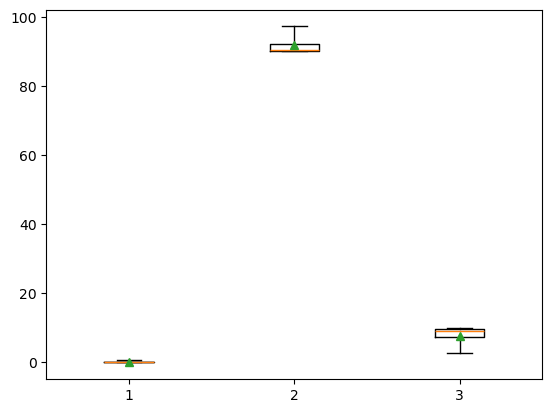

In [25]:
# Coverage by income quartile
df['income_quartile'] = pd.qcut(df['income'], q=4, labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])
income_coverage = pd.crosstab(df['income_quartile'], df['hicoverage'], normalize='index') * 100
print("\nCoverage by Income Quartile (%):")
print(income_coverage.round(1))

# Visualization
plt.boxplot(income_coverage, showmeans=True, whis = 99)
plt.show()

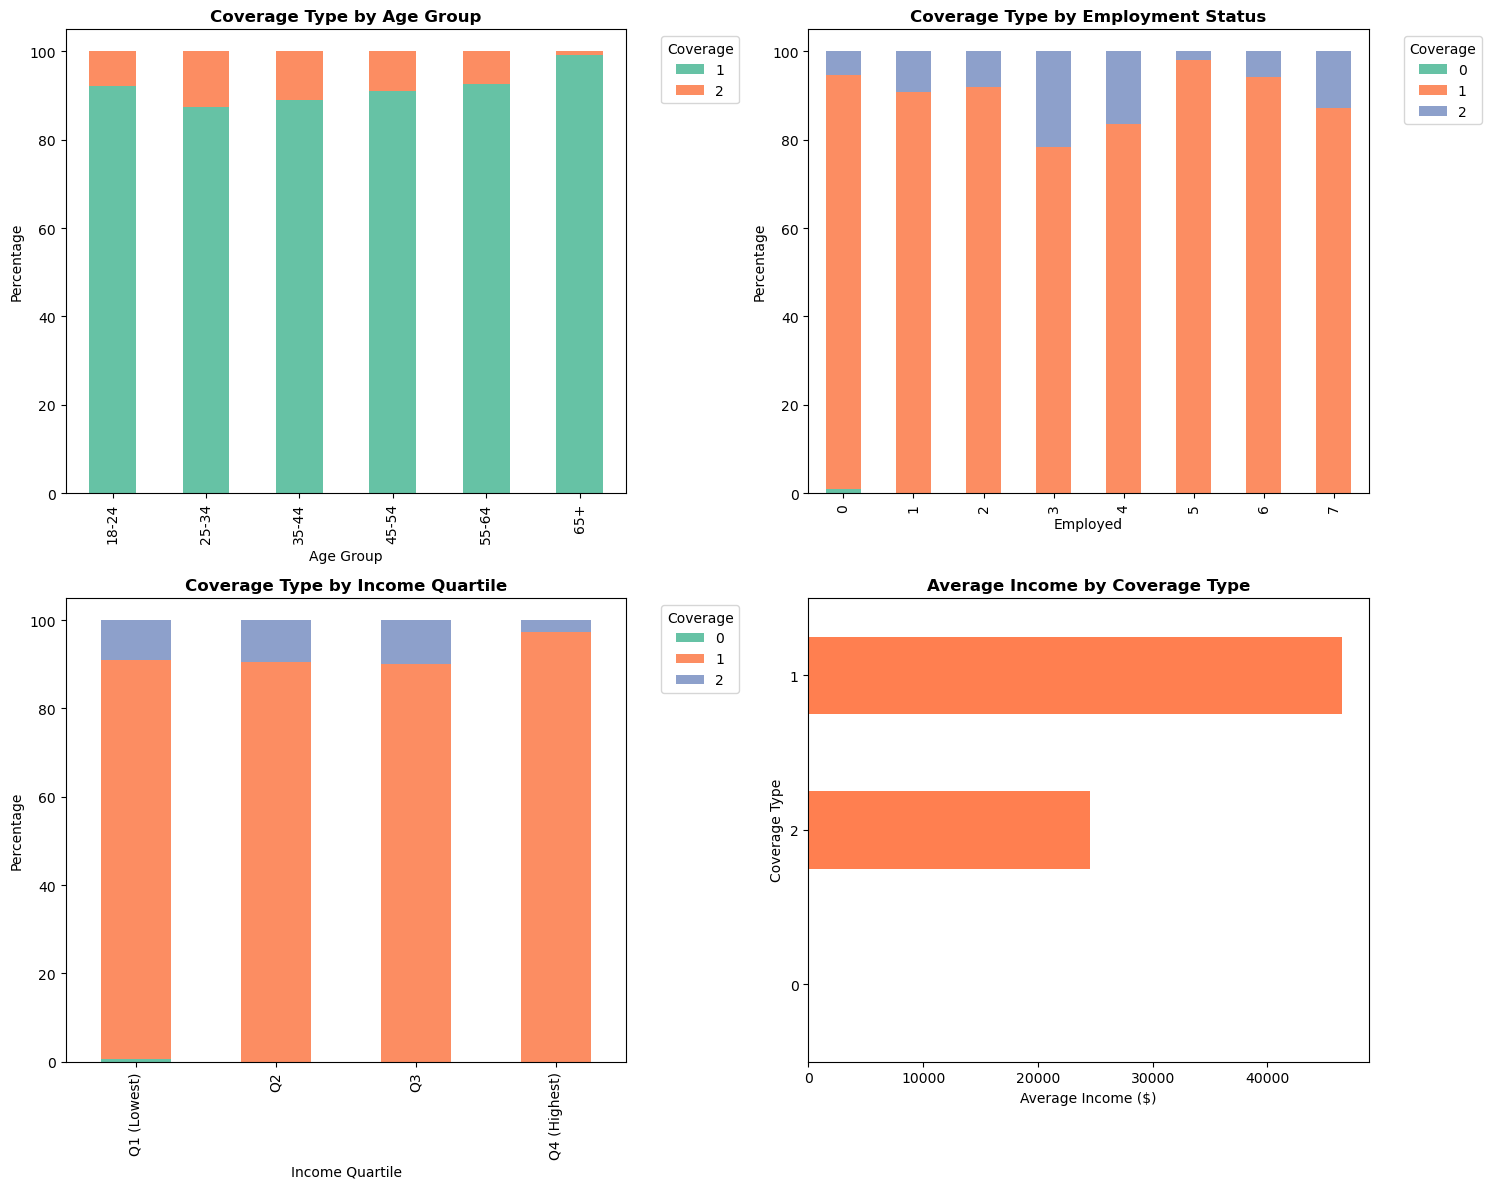

In [26]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Age group
age_coverage.plot(kind='bar', stacked=True, ax=axes[0, 0], color=sns.color_palette('Set2', len(age_coverage.columns)))
axes[0, 0].set_title('Coverage Type by Age Group', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Age Group')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].legend(title='Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
# axes[0, 0].tick_params(axis='x', rotation=45)

# Employment
emp_coverage.plot(kind='bar', stacked=True, ax=axes[0, 1],
                 color=sns.color_palette('Set2', len(emp_coverage.columns)))
axes[0, 1].set_title('Coverage Type by Employment Status', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Employed')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].legend(title='Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
# axes[0, 1].set_xticklabels(['No', 'Yes'])

# Income quartile
income_coverage.plot(kind='bar', stacked=True, ax=axes[1, 0],
                    color=sns.color_palette('Set2', len(income_coverage.columns)))
axes[1, 0].set_title('Coverage Type by Income Quartile', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Income Quartile')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].legend(title='Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
# axes[1, 0].tick_params(axis='x', rotation=45)

# Average income by coverage type
income_by_coverage = df.groupby('hicoverage')['income'].mean().sort_values()
income_by_coverage.plot(kind='barh', ax=axes[1, 1], color='coral')
axes[1, 1].set_title('Average Income by Coverage Type', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Average Income ($)')
axes[1, 1].set_ylabel('Coverage Type')

plt.tight_layout()
plt.savefig('coverage_demographics.png', dpi=300, bbox_inches='tight')

In [27]:
# Create copy
df_model = df.copy()

# Create derived features
valid_income = df['income'] > 0
df_model['income_log'] = np.log1p(valid_income)
df_model['income_per_capita'] = df_model['income'] / df_model['family_size']
df_model['age_squared'] = df_model['age'] ** 2
df_model['is_senior'] = (df_model['age'] >= 65).astype(int)
df_model['is_young_adult'] = (df_model['age'] < 26).astype(int)

# Income categories
df_model['income_category'] = pd.cut(df_model['income'], 
                                     bins=[0, 25000, 50000, 100000, float('inf')],
                                     labels=['Low', 'Medium', 'High', 'Very High'])

print(f"Created {len(df_model.columns) - len(df.columns)} new features")
print(f"Total features: {len(df_model.columns)}")

Created 6 new features
Total features: 16


In [44]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

categorical_features = ['education', 'marital_status', 'race', 'income']
numerical_features = ['age', 'income_log', 'family_size', 'employed', 
                     'income_per_capita', 'age_squared', 'is_senior', 'is_young_adult']

# Encode categorical variables
df_encoded = df_model.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Create feature matrix
feature_cols = numerical_features + [col + '_encoded' for col in categorical_features]
X = df_encoded[feature_cols]
y = df_encoded['hicoverage']

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)


In [47]:
# np.isnan(X.any()) #and gets False
np.isfinite(X.all()) #and gets True

age                       True
income_log                True
family_size               True
employed                  True
income_per_capita         True
age_squared               True
is_senior                 True
is_young_adult            True
education_encoded         True
marital_status_encoded    True
race_encoded              True
income_encoded            True
dtype: bool

In [60]:
from sklearn.impute import SimpleImputer

X.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X)

X_imputed = imputer.transform(X)

In [64]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"Coverage types: {le_target.classes_}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Shouldnt be getting an infinite number TODO: order in which things are happening?
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Train and evaluate models
results = {}

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    
    # Use scaled data for Logistic Regression, original for tree-based
    if 'Logistic' in model_name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))
    
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'y_test': y_test
    }

# Plot model comparison
plot_model_comparison(results, le_target)

# Return best model and encoders
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\n*** Best Model: {best_model_name} (Accuracy: {results[best_model_name]['accuracy']:.4f}) ***")

return results[best_model_name]['model'], le_target, label_encoders, scaler, feature_cols


Training set: 115412 samples
Test set: 28853 samples
Number of features: 14
Coverage types: [0 1 2]

--- Training Logistic Regression ---
Accuracy: 0.9207

Classification Report:


/opt/anaconda3/envs/anaconda-snowflake/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: object of type 'numpy.int64' has no len()

In [173]:
X = df_encoded[feature_cols]

In [174]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [175]:
scaler = StandardScaler()

In [176]:
X_train_scaled = scaler.fit_transform(X_train)

/opt/anaconda3/envs/anaconda-snowflake/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').